In [159]:
from utils.stringutils import linewise_tokenize, wordwise_tokenize, string_edit_distance


In [196]:
corpus = """import 'dart:convert';
import 'dart:ffi';

import 'package:cloud_firestore/cloud_firestore.dart';
import 'package:firebase_auth/firebase_auth.dart';
import 'package:flutter/cupertino.dart';
import 'package:flutter/material.dart';
import 'package:teamtrack/components/misc/PlatformGraphics.dart';
import 'package:teamtrack/models/AppModel.dart';
import 'package:provider/provider.dart';
import 'package:teamtrack/models/GameModel.dart';
import 'package:teamtrack/providers/Auth.dart';
import 'package:teamtrack/providers/PushNotifications.dart';
import 'package:teamtrack/providers/Theme.dart';
import 'package:teamtrack/views/auth/Login.dart';
import 'package:teamtrack/views/home/events/EventsList.dart';
import 'package:teamtrack/views/inbox/BlockList.dart';
import 'package:teamtrack/views/inbox/Inbox.dart';
import 'package:teamtrack/views/templates/TemplatesList.dart';
import 'package:collection/collection.dart';



class LandingPage extends StatefulWidget {
  const LandingPage({super.key});

  @override
  _LandingPageState createState() => _LandingPageState();
}

enum Tab {
  events,
  inbox,
  blocked_users,
  templates,
}

var tab = Tab.events;

class _LandingPageState extends State<LandingPage> {
  EventType? _newType;
  String? _newName;
  Double? _newNum;

  @override
  void initState() {
    super.initState();
    PushNotifications.onNotifications.stream.listen(onClickedNotification);
  }

  void onClickedNotification(String? payload) =>
      setState(() => tab = Tab.inbox);

  Widget title() {
    switch (tab) {
      case Tab.inbox:
        return Text("Inbox");
      case Tab.blocked_users:
        return Text("Blocked Users");
      case Tab.templates:
        return Text("Templates");
      case Tab.events:
        return Center(child:Text("TeamTrack",textScaleFactor: 1.5,));
    }
  }

  Widget body() {
    switch (tab) {
      case Tab.inbox:
        return Inbox();
      case Tab.blocked_users:
        return BlockList();
      case Tab.templates:
        return TemplatesList();
      case Tab.events:
        return EventsList();
    }
  }

  @override
  Widget build(BuildContext context) {
    final themeChange = context.watch<DarkThemeProvider>();
    setState(() {

      themeChange.darkTheme = true;
    });
    final TextEditingController controller = new TextEditingController();
    for (var event in dataModel.events.where((e) => !e.shared)) {
      final user = context.read<User?>();
      event.author = TeamTrackUser.fromUser(user);
      event.role = Role.admin;
    }
    return StreamBuilder<DocumentSnapshot<Map<String, dynamic>>?>
      (

      //get data from database
      stream: firebaseFirestore
          .collection('users')
          .doc(context.read<User?>()?.uid)
          .snapshots(),
      builder: (context, snapshot) {
        var data = snapshot.data?.data();
        dataModel.sharedEvents.clear();
        dataModel.inbox.clear();
        dataModel.blockedUsers.clear();
        (data?['events'] as Map?)?.values.forEach((value) {
          try {
            final event = Event.fromJson(value);
            event.shared = true;
            dataModel.sharedEvents.add(event);
          } catch (e) {}
        });
        (data?['inbox'] as Map?)?.values.forEach((value) {
          try {
            final event = Event.fromJson(value);
            event.shared = true;
            dataModel.inbox.add(event);
          } catch (e) {}
        });
        (data?['blockedUsers'] as Map?)?.keys.forEach((key) {
          try {

            final ttuser =
            TeamTrackUser.fromJson(data?['blockedUsers']?[key], key);
            dataModel.blockedUsers.add(ttuser);
          } catch (e) {
            dataModel.blockedUsers.add(TeamTrackUser(
                role: Role.viewer,
                uid: key,
                email: data?['blockedUsers']?[key]));
          }
        });


        //light mode/dark mode at the top
        return Scaffold(
          appBar: AppBar(
            backgroundColor: Theme.of(context).colorScheme.primary,
            title: title(),
            actions: [
              SizedBox(
                width: 50,
              )
              // IconButton(
              //   tooltip: themeChange.darkTheme ? "Light Mode" : "Dark Mode",
              //   icon: themeChange.darkTheme
              //       ? Icon(CupertinoIcons.sun_max)
              //       : Icon(CupertinoIcons.moon),
              //   onPressed: () {
              //     setState(() =>
              //     themeChange.darkTheme = !themeChangeProvider.darkTheme);
              //   },
              // )
            ],
          ),


          //idk
          body: body(),
          floatingActionButton: tab == Tab.events
              ? null
              : null,



          drawer: Drawer(
            elevation: 1,
            child: Material(
              child: Column(
                mainAxisSize: MainAxisSize.min,
                children: [


                  //change display name
                  DrawerHeader(
                    decoration: BoxDecoration(
                      color: Theme.of(context).colorScheme.primary,
                    ),
                    child: Row(
                      children: [
                        Padding(
                          padding: const EdgeInsets.only(left: 5.0),
                          child: Row(
                            children: [
                              Column(
                                crossAxisAlignment: CrossAxisAlignment.start,
                                mainAxisAlignment:
                                MainAxisAlignment.spaceEvenly,
                                mainAxisSize: MainAxisSize.min,
                                children: [
                                  if (context.read<User?>()?.photoURL != null)
                                    Padding(
                                      padding: EdgeInsets.only(bottom:10)
                                      ,child:ClipRRect(
                                      borderRadius: BorderRadius.circular(300),
                                      child: Image.network(
                                        context.read<User?>()!.photoURL!,
                                        height: 70,
                                      ),
                                    ),
                                    )
                                  else
                                    Padding(
                                        padding: EdgeInsets.only(bottom:10),
                                        child:
                                        Icon(Icons.account_circle, size: 70)
                                    ),
                                  Text(
                                    context.read<User?>()?.displayName ??
                                        "Guest",
                                    style: TextStyle(color: Colors.white,
                                        fontSize: 18,
                                      fontWeight: FontWeight.w700,
                                    ),
                                  ),
                                  Text(
                                    context.read<User?>()?.email ?? "",
                                    style: TextStyle(color: Colors.black,
                                      fontWeight: FontWeight.w400,
                                      fontSize: 14,),
                                  ),
                                ],
                              ),
                            ],
                          ),
                        ),
                        Spacer(),
                        Column(
                          children: [
                            IconButton(
                              icon: Icon(Icons.edit,
                            color: Theme.of(context).colorScheme.onBackground),
                              onPressed: () {
                                showPlatformDialog(
                                  context: context,
                                  builder: (_) => PlatformAlert(
                                    title: Text("Change User Details"),
                                    content: Column(
                                      mainAxisSize: MainAxisSize.min,
                                      children:[
                                        PlatformTextField(
                                          textInputAction: TextInputAction.done,
                                          placeholder: "Display Name",
                                          keyboardType: TextInputType.name,
                                          controller: controller,
                                        ),
                                    /*    PlatformTextField(
                                          textInputAction: TextInputAction.done,
                                          placeholder: "Profile Picture URL",
                                          keyboardType: TextInputType.url,
                                          controller: controller2,
                                        ),*/
                                      ],),
                                    actions: [
                                      PlatformDialogAction(
                                        child: Text("Cancel"),
                                        onPressed: () {
                                          Navigator.pop(context);
                                        },
                                      ),
                                      PlatformDialogAction(
                                        child: Text("Confirm"),
                                        onPressed: () async {
                                          if (controller.text.isNotEmpty)
                                            await context
                                                .read<User?>()
                                                ?.updateDisplayName(
                                              controller.text,
                                            );

                                  /*        if (controller2.text.isNotEmpty)
                                            await context
                                                .read<User?>()
                                                ?.updatePhotoURL(
                                              controller2.text,
                                            );*/
                                          Navigator.pop(context);
                                          showPlatformDialog(
                                            context: context,
                                            builder: (_) => PlatformAlert(
                                              title: Text("Success"),
                                              content: Text(
                                                "Restart your app",
                                              ),
                                              actions: [
                                                PlatformDialogAction(
                                                  child: Text("Okay"),
                                                  onPressed: () {
                                                    Navigator.pop(context);
                                                  },
                                                ),
                                              ],
                                            ),
                                          );
                                        },
                                      ),
                                    ],
                                  ),
                                );
                              },
                              highlightColor: Colors.red,
                            ),
                            Spacer(),
                          ],
                        )
                      ],
                    ),
                  ),




                  Column(
                    mainAxisSize: MainAxisSize.min,
                    children: [


                      //Events button
                      ListTile(
                        leading: Icon(Icons.list,
                            color: Theme.of(context).colorScheme.onBackground),
                        title: Text("Events"),
                        onTap: () {
                          setState(() => tab = Tab.events);
                          Navigator.of(context).pop();
                        },
                      ),


                      //Templates button
                      if (!NewPlatform.isWeb)
                        ListTile(
                          leading: Icon(CupertinoIcons.square_stack,
        color: Theme.of(context).colorScheme.onBackground),
                          title: Text("Templates"),
                          onTap: () {
                            setState(() => tab = Tab.templates);
                            Navigator.of(context).pop();
                          },
                        ),


                      //Inbox button
                      if (!(context.read<User?>()?.isAnonymous ?? true))
                        ListTile(
                          leading: Icon(Icons.inbox_rounded,
        color: Theme.of(context).colorScheme.onBackground),
                          title: Text("Inbox"),
                          trailing:
                          (data?['inbox'] as Map?)?.entries.length == 0
                              ? null
                              : Container(
                            decoration: ShapeDecoration(
                              color: Colors.red,
                              shape: CircleBorder(),
                            ),
                            child: Padding(
                              padding: const EdgeInsets.all(8.0),
                              child: Text(
                                (data?['inbox'] as Map?)
                                    ?.entries
                                    .length
                                    .toString() ??
                                    "0",
                              ),
                            ),
                          ),
                          onTap: () {
                            setState(() => tab = Tab.inbox);
                            Navigator.of(context).pop();
                          },
                        ),


                      //If user isn't anon than list blocked users
                      if (!(context.read<User?>()?.isAnonymous ?? true))
                        ListTile(
                          leading: Icon(Icons.people_alt,
        color: Theme.of(context).colorScheme.onBackground),
                          title: Text("Blocked Users"),
                          onTap: () {
                            setState(() => tab = Tab.blocked_users);
                            Navigator.of(context).pop();
                          },
                        ),


                      //if user anon then list link acc
                      if (context.read<User?>()?.isAnonymous ?? false)
                        ListTile(
                          leading: Icon(Icons.link,
        color: Theme.of(context).colorScheme.onBackground),
                          title: Text("Link Account"),
                          onTap: () => Navigator.of(context).push(
                            platformPageRoute(
                              builder: (context) => LoginView(returnBack: true),
                            ),
                          ),
                        ),


                      //Sign out button
                      ListTile(
                        leading: Icon(Icons.logout,
                        color: Theme.of(context).colorScheme.onBackground),
                        title: Text('Sign Out'),
                        onTap: () {
                          showPlatformDialog(
                            context: context,
                            builder: (context) => PlatformAlert(
                              title: Text('Sign Out'),
                              content: Text('Are you sure?'),
                              actions: [
                                PlatformDialogAction(
                                  isDefaultAction: true,
                                  child: Text('Cancel'),
                                  onPressed: () => Navigator.of(context).pop(),
                                ),
                                PlatformDialogAction(
                                  isDestructive: true,
                                  child: Text('Sign Out'),
                                  onPressed: () {
                                    Navigator.of(context).pop();
                                    context
                                        .read<AuthenticationService>()
                                        .signOut();
                                  },
                                ),
                              ],
                            ),
                          );
                        },
                      ),

                      //delete acc button
                      ListTile(
                        leading: Icon(Icons.delete_forever,
        color: Theme.of(context).colorScheme.onBackground),
                        title: Text('Delete Account'),
                        onTap: () {
                          showPlatformDialog(
                            context: context,
                            builder: (context) => PlatformAlert(
                              title: Text('Are you sure?'),
                              content: Text('This action cannot be reversed, and all data will be lost permanently.'),
                              actions: [
                                PlatformDialogAction(
                                  isDefaultAction: true,
                                  child: Text('Cancel'),
                                  onPressed: () => Navigator.of(context).pop(),
                                ),
                                PlatformDialogAction(
                                  isDestructive: true,
                                  child: Text('Delete Account'),
                                  onPressed: () async {

                                    //pull request comment
                                    //PROBLEMS TO ADDRESS:
                                    //1. Security issues caused by cloud function
                                    //2. Swapping the author(idk if this is done by default. need to test)
                                    //3. Testing with groups of many people

                                    User? user=FirebaseAuth.instance.currentUser;
                                    final uid = user?.uid;
                                    final email = FirebaseAuth.instance.currentUser?.email;

                                    setState(() => dataModel.events.clear());
                                    dataModel.saveEvents();

                                    //deal with shared events
                                    List<Event> sharedEvents=dataModel.sharedEvents;

                                    //debugPrint('HEREEEEEEEEEEEEEEEE');

                                    try {
                                      for (Event ev in sharedEvents) {
                                        //debugPrint('REEEEEEEEEE $uid');

                                        //temporary variables
                                        TeamTrackUser? firstEditor;
                                        TeamTrackUser? firstViewer;
                                        TeamTrackUser? targetUser;
                                        setState(() => {});

                                        //update users list from firebase
                                        final map = await ev.getRef()?.once();
                                        ev.updateLocal(
                                          json.decode(
                                            json.encode(
                                              map?.snapshot.value,
                                            ),
                                          ),
                                          context,
                                        );
                                        setState(() => {});

                                        List<TeamTrackUser> users = ev.users;
                                        setState(() => {});

                                        //debugPrint("THISSSSSSSSSSSSSSSSSS");

                                        //If user isn't admin or if there is another admin in the event, remove perms
                                        if (users
                                            .firstWhereOrNull((
                                            element) => element.uid == uid)
                                            ?.role != Role.admin
                                            || users.firstWhereOrNull((
                                                element) =>
                                            element.role == Role.admin &&
                                                element.uid != uid) != null) {
                                          await ev.modifyUser(
                                              uid: uid, role: null);

                                          //setState(() => {});
                                        }
                                        //If there is only one person in the event(this acc) delete the event
                                        else if (users.singleOrNull != null) {
                                          await ev.getRef()?.remove();
                                          setState(() => {});
                                          //delete event
                                        }
                                        //If neither of those apply(user is admin+there are only editors/viewers),
                                        //passes admin on to one of them and then removes perms
                                        else {
                                          firstEditor = users.firstWhereOrNull((
                                              element) =>
                                          element.role == Role.editor);
                                          firstViewer = users.firstWhereOrNull((
                                              element) =>
                                          element.role == Role.viewer);
                                          setState(() => {});

                                          if (firstEditor != null)
                                            targetUser = firstEditor;
                                          else if (firstViewer != null)
                                            targetUser = firstViewer;
                                          setState(() => {});


                                          await ev.modifyUser(
                                              uid: targetUser?.uid,
                                              role: Role.admin);

                                          //setState(() => {});

                                          await ev.modifyUser(
                                              uid: uid, role: null);

                                          setState(() => {});
                                        }
                                      }
                                    }
                                    catch(err)
                                    {
                                      debugPrint("this code was written while listening to egirl asmr");
                                    }
                                      dataModel.saveEvents();
                                      setState(() => {});

                                      //delete the user
                                      try {
                                        user?.delete().then((yikes) async
                                        {
                                          await
                                          FirebaseFirestore.instance.collection(
                                              "users")
                                              .doc(uid)
                                              .delete();
                                        });
                                        setState(() => {});
                                      }
                                      catch(err)
                                      {
                                        debugPrint("lol");
                                      }

                                      //sign out
                                    context
                                          .read<AuthenticationService>()
                                          .signOut();
                                      Navigator.of(context).pop();


                                    },
                                ),
                              ],
                            ),
                          );
                        },
                      ),

                    ],
                  )



                ],
              ),
            ),
          ),
        );
      },
    );
  }

  void _onPressed() {
    if (NewPlatform.isIOS)
      showCupertinoModalPopup(
        context: context,
        builder: (context) => CupertinoActionSheet(
          message: Text('Select Event Type'),
          actions: [
            CupertinoActionSheetAction(
              onPressed: () {
                _newType = EventType.local;
                Navigator.pop(context);
                _chosen();
              },
              child: Row(
                mainAxisAlignment: MainAxisAlignment.spaceBetween,
                children: [
                  Icon(CupertinoIcons.person_3_fill),
                  Text('In-Person Event'),
                  Text(''),
                ],
              ),
            ),
            CupertinoActionSheetAction(
              onPressed: () {
                _newType = EventType.remote;
                Navigator.pop(context);
                _chosen();
              },
              child: Row(
                  mainAxisAlignment: MainAxisAlignment.spaceBetween,
                  children: [
                    Icon(CupertinoIcons.rectangle_stack_person_crop_fill),
                    Text('Remote Event'),
                    Text('')
                  ]),
            ),
            CupertinoActionSheetAction(
              onPressed: () {
                _newType = EventType.analysis;
                Navigator.pop(context);
                _chosen();
              },
              child: Row(
                mainAxisAlignment: MainAxisAlignment.spaceBetween,
                children: [
                  Icon(CupertinoIcons.rocket),
                  Text('Driver Analysis'),
                  Text(''),
                ],
              ),
            ),
          ],
          cancelButton: CupertinoActionSheetAction(
            child: Text('Cancel'),
            onPressed: () => {Navigator.pop(context)},
            isDefaultAction: true,
          ),
        ),
      );
    else
      showModalBottomSheet(
        context: context,
        builder: (context) => Column(
          mainAxisSize: MainAxisSize.min,
          mainAxisAlignment: MainAxisAlignment.end,
          children: [
            Container(
              decoration: BoxDecoration(
                border: Border.all(
                  color: Theme.of(context).splashColor,
                  width: 1,
                ),
              ),
              child: ListTileTheme(
                iconColor: Theme.of(context).colorScheme.primary,
                child: ListTile(
                  onTap: () {
                    _newType = EventType.local;
                    Navigator.pop(context);
                    _chosen();
                  },
                  leading: Icon(CupertinoIcons.person_3_fill),
                  title: Text('In-Person Event'),
                ),
              ),
            ),
            Container(
              decoration: BoxDecoration(
                border: Border.all(
                  color: Theme.of(context).splashColor,
                  width: 1,
                ),
              ),
              child: ListTileTheme(
                iconColor: Theme.of(context).colorScheme.primary,
                child: ListTile(
                  onTap: () {
                    _newType = EventType.remote;
                    Navigator.pop(context);
                    _chosen();
                  },
                  leading:
                  Icon(CupertinoIcons.rectangle_stack_person_crop_fill),
                  title: Text('Remote Event'),
                ),
              ),
            ),
            Container(
              decoration: BoxDecoration(
                border: Border.all(
                  color: Theme.of(context).splashColor,
                  width: 1,
                ),
              ),
              child: ListTileTheme(
                iconColor: Theme.of(context).colorScheme.primary,
                child: ListTile(
                  onTap: () {
                    _newType = EventType.analysis;
                    Navigator.pop(context);
                    _chosen();
                  },
                  leading: Icon(CupertinoIcons.rocket),
                  title: Text('Driver Analysis'),
                ),
              ),
            ),
          ],
        ),
      );
  }

  void _chosen() => showPlatformDialog(
    context: context,
    builder: (BuildContext context) => PlatformAlert(
      title: Text(
          'New ${_newType == EventType.remote ? 'Remote Event' :(_newType == EventType.local ? 'In Person Event': 'Driver Analysis')}'),
        content: Column(
          mainAxisSize: MainAxisSize.min,
          children:[
            PlatformTextField(
              textInputAction: TextInputAction.done,
              keyboardType: TextInputType.name,
              textCapitalization: TextCapitalization.words,
              onChanged: (String input) {
                _newName = input;
              },
              placeholder: 'Enter name',
            ),
          ],
      ),
      actions: [
        PlatformDialogAction(
          isDefaultAction: true,
          child: Text('Cancel'),
          onPressed: () {
            _newName = '';
            _newNum = 0.0 as Double?;
            Navigator.of(context).pop();
          },
        ),
        PlatformDialogAction(
          isDefaultAction: false,
          child: Text('Add'),
          onPressed: () {
            setState(
                  () {
                if (_newName!.isNotEmpty&&_newType!=EventType.analysis)
                  dataModel.events.add(Event(
                    name: _newName ?? Statics.gameName,
                    type: _newType ?? EventType.remote,
                    gameName: Statics.gameName,
                  ));
                if(_newName!.isNotEmpty&&_newType==EventType.analysis){
                  dataModel.events.add(Event(
                    name: _newName ?? Statics.gameName,
                    type: _newType ?? EventType.remote,
                    gameName: Statics.gameName,
                  ));
                }
                dataModel.saveEvents();
                _newName = '';
              },
            );
            Navigator.of(context).pop();
          },
        ),
      ],
    ),
  );
}"""

In [270]:
substring = """Widget body() {
    switch (tab) {
      case Tab.inbox:
        return Inbox();
        // INSERT RANDOM GARBAGE HERE
        //  JUST TO SHOW THE ALGO WORKS
      //SERIOUSLY
        return EventsList();
    }
  }
"""

In [267]:
import numpy as np

def ktuple_matching(query, database, k):
    query_kmers = {}
    for i in range(len(query) - k + 1):
        kmer = ''.join(part.strip() for part in query[i:i+k])
        if kmer in query_kmers:
            query_kmers[kmer].append(i)
        else:
            query_kmers[kmer] = [i]
    
    matches = []
    for i in range(len(database) - k + 1):
        kmer = ''.join(part.strip() for part in database[i:i+k])
        if kmer in query_kmers:
            for q_pos in query_kmers[kmer]:
                matches.append((q_pos, i))
    
    return matches

def find_top_n_diagonals(matches, n):
    diagonal_scores = {}
    for q_pos, db_pos in matches:
        diag = q_pos - db_pos
        if diag in diagonal_scores:
            diagonal_scores[diag] += 1
        else:
            diagonal_scores[diag] = 1
    
    sorted_diagonals = sorted(diagonal_scores.items(), key=lambda item: item[1], reverse=True)
    top_diagonals = [diag for diag, score in sorted_diagonals[:n]]
    
    return top_diagonals

def banded_dp(query, database, band_width, top_diagonals, match_score=3, mismatch_penalty=3, gap_penalty=1, processing=None):
    best_score = float('-inf')
    best_alignment = None
    
    for diag in top_diagonals:
        q_start = max(0, diag)
        db_start = max(0, -diag)
        q_end = min(len(query), len(database) + diag)
        db_end = min(len(database), len(query) - diag)
        
        dp = np.zeros((q_end - q_start + 1, db_end - db_start + 1))
        
        for i in range(1, q_end - q_start + 1):
            for j in range(max(1, i - band_width), min(db_end - db_start + 1, i + band_width)):
                q, d = query[q_start + i - 1], database[db_start + j - 1]
                if processing:
                    q = processing(q)
                    d = processing(d)
                multiplier = 1 + len(max(q, d, key=len))
                match = dp[i-1, j-1] + (match_score if q == d else -mismatch_penalty) * multiplier
                delete = dp[i-1, j] - gap_penalty * multiplier
                insert = dp[i, j-1] - gap_penalty * multiplier
                dp[i, j] = max(match, delete, insert)
        
        if dp[-1, -1] > best_score:
            best_score = dp[-1, -1]
            best_alignment = (q_start, db_start, q_end, db_end)
    
    return best_alignment, best_score

def fasta_algorithm(database, query, k=12, n=3, band_width=10, match_score=3, mismatch_penalty=3, gap_penalty=1):
    matches = ktuple_matching(query, database, k)
    top_diagonals = find_top_n_diagonals(matches, n)
    best_alignment, best_score = banded_dp(query, database, band_width, top_diagonals, match_score, mismatch_penalty, gap_penalty, processing=lambda x: x.lower().strip())
    if best_alignment is None:
        return None, float('-inf')
    q_start, db_start, q_end, db_end = best_alignment
    best_substring = database[db_start:db_end]
    
    return best_substring, best_score

In [272]:
def find_most_similar_substring(corpus, query):
    # 1. Tokenize the corpus and query into lines
    linewise_tokenized_corpus = linewise_tokenize(corpus)
    linewise_tokenized_substring = linewise_tokenize(query)

    # 2. Run the FASTA algorithm
    result, score = fasta_algorithm(linewise_tokenized_corpus, linewise_tokenized_substring, k=3, band_width=5, gap_penalty=0)
    if result is None:
        return None, float('-inf')

    # 3. Do a second pass with wordwise tokeization
    wordwise_tokenized_result = wordwise_tokenize(''.join(result))
    wordwise_tokenized_query = wordwise_tokenize(query)
    result, score = fasta_algorithm(wordwise_tokenized_result, wordwise_tokenized_query, k=3, n=3, band_width=3, match_score=2, mismatch_penalty=3, gap_penalty=5)
    if result is None:
        return None, float('-inf')
    return ''.join(result), score

# Example usage:
result, _ = find_most_similar_substring(corpus, substring)
print("Closest substring in database to query:", result)

Closest substring in database to query: Widget body() {
    switch (tab) {
      case Tab.inbox:
        return Inbox();
      case Tab.blocked_users:
        return BlockList();
      case Tab.templates:
        return TemplatesList();
      case Tab.events:
        return EventsList();


In [246]:
import time, random, tqdm, numpy as np

times = []
for length in tqdm.tqdm(range(2000)):
    sub_times = []
    for i in range(2):
        start_pos = random.randint(0, len(corpus) - length)
        substring = corpus[start_pos:start_pos + length]
        start = time.time()
        best_match, best_score = find_most_similar_substring(corpus, substring)
        end = time.time()
        sub_times.append(end - start)
    times.append(np.mean(sub_times))

100%|██████████| 2000/2000 [00:29<00:00, 68.70it/s]


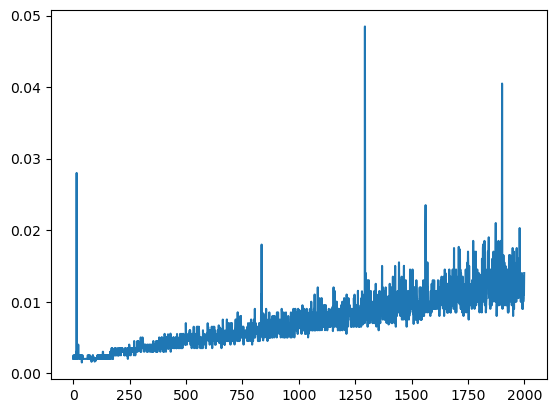

In [247]:
from matplotlib import pyplot as plt

plt.plot(times)
plt.show()